<h1>Лабораторная работа 1</h1>
Енгоян Сергей и Ключковский Даниил А-01м-25<br>
Визуальный анализ временного ряда и обработка аномальных измерений.<br>
Непараметрические и параметрические методы обнаружения и выделения <br>
компонент временного ряда, анализ случайности и стационарности временных рядов.

In [658]:
import numpy as np
import matplotlib.pyplot as plt

<h3>1) Моделирование временного ряда</h3>

In [659]:
def time_series(t, N, num=1):
    e = np.random.normal(loc=0, scale=1, size=N)
    a0 = np.random.uniform(0.1, 0.5)
    a1 = np.random.uniform(0.01, 0.1)
    a2 = np.random.uniform(0.5, 1.0)

    result = []
    if num == 1:
        for i in range(N):
            result.append(a0 * np.sin(a1 * 2 * np.pi * t[i]) + a2 * e[i])
        print('A =', a0, 'f =', a1, 'a2 =', a2)
        return result
    elif num == 2:
        for i in range(N):
            result.append(np.exp(0.1 * t[i]) + 2 * e[i])
        return result

A = 0.15786342844303283 f = 0.09929036082915986 a2 = 0.9539538602721409


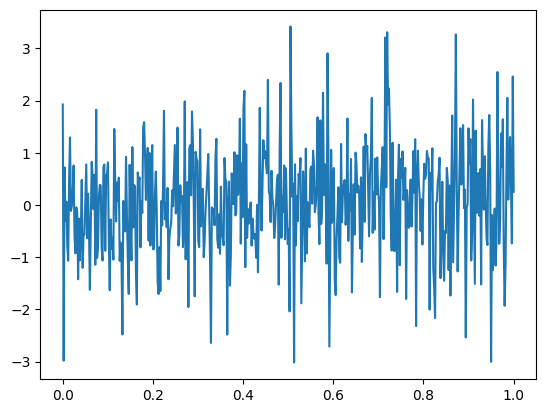

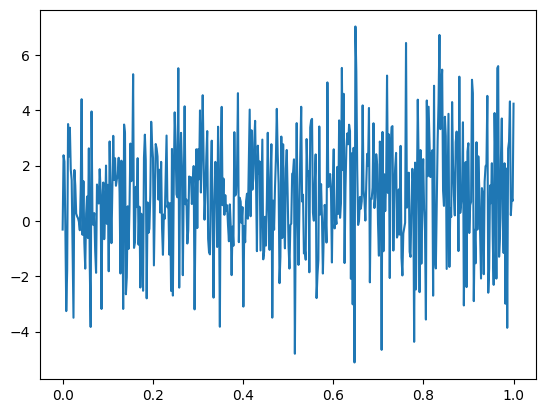

In [660]:
N = 500        # Количество точек
T = 1           # Время моделирования

t = np.linspace(0, T, N)

y1 = time_series(t, N, num=1)
y2 = time_series(t, N, num=2)

plt.plot(t, y1)
plt.show()
plt.plot(t, y2)
plt.show()

<h3>2) Анализ аномалий с помощью эллипса рассеяния</h3>

In [661]:
from matplotlib.patches import Ellipse
from scipy.stats import chi2

In [662]:
def diffs(X):
    X = np.array(X, dtype=float)
    N = len(X)

    diff_x = np.full(N, np.nan)  # разница с предыдущим
    diff_y = np.full(N, np.nan)  # разница с следующим

    # начиная со второго элемента до последнего, считаем разницу с предыдущим
    diff_x[1:-1] = X[1:-1] - X[0:-2]

    # начиная со второго до предпоследнего, считаем разницу с следующим
    diff_y[1:-1] = X[2:] - X[1:-1]

    return diff_x, diff_y

In [663]:
def ellips(Y, PARAM):
    dx, dy = diffs(Y)

    # Очистка от NaN
    mask = ~np.isnan(dx) & ~np.isnan(dy)
    dx_clean = dx[mask]
    dy_clean = dy[mask]

    # Середина эллипса
    mean_x = np.mean(dx_clean)
    mean_y = np.mean(dy_clean)

    # Ковариационная матрица
    cov = np.cov(dx_clean, dy_clean)

    # Главные оси
    vals, vecs = np.linalg.eig(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]

    # Размеры эллипса
    confidence_val = chi2.ppf(PARAM, df=2)
    width, heigth = 2 * np.sqrt(confidence_val * vals)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    el = Ellipse(
        xy=(mean_x, mean_y),
        width=width,
        height=heigth,
        angle=angle,
        edgecolor='r',
        facecolor='none',
        lw=2
    )

    # Махаланобисово расстояние
    inv_cov = np.linalg.inv(cov)
    diffs_array = np.vstack([dx_clean - mean_x, dy_clean - mean_y]).T
    mahal_sq = np.sum(diffs_array @ inv_cov * diffs_array, axis=1)

    # Отбор аномалий
    in_quadrant = ((dx_clean < 0) & (dy_clean > 0)) | ((dx_clean > 0) & (dy_clean < 0))
    outliers_mask = (mahal_sq > confidence_val) & in_quadrant

    # Координаты и индексы аномалий
    outlier_x = dx_clean[outliers_mask]
    outlier_y = dy_clean[outliers_mask]
    outlier_indices = np.where(mask)[0][outliers_mask]

    # Запись аномалий
    anomalies = []
    for x, y, idx in zip(outlier_x, outlier_y, outlier_indices):
        anomalies.append(idx)
        # print(f"{idx} : {Y[idx]} {x} {y}")

    fig, ax = plt.subplots()
    ax.spines['left'].set_position(('data', mean_x))
    ax.spines['bottom'].set_position(('data', mean_y))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.scatter(dx_clean, dy_clean, s=10, label='Точки')
    ax.scatter(outlier_x, outlier_y, color='orange', s=30, label='Аномалии')

    for x, y, idx in zip(outlier_x, outlier_y, outlier_indices):
        ax.annotate(str(idx), (x, y), textcoords="offset points", xytext=(5, 5), ha='center', fontsize=8)

    ax.add_patch(el)
    ax.legend()
    plt.show()

    return anomalies

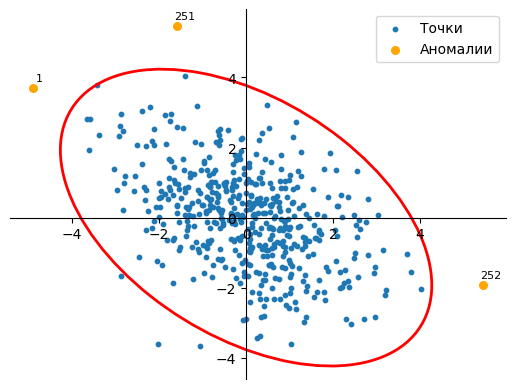

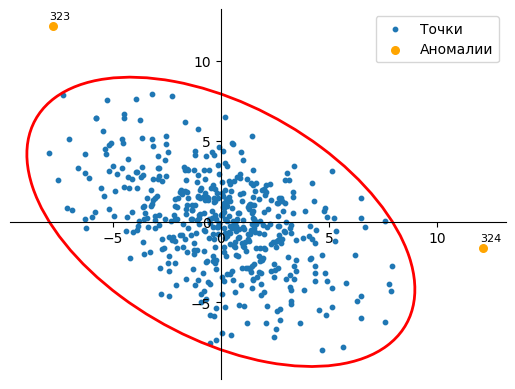

In [664]:
PARAM = 0.99

anom_y1 = ellips(y1, PARAM)

anom_y2 = ellips(y2, PARAM)

In [665]:
def smoothing(Y, anomalies):
    X = Y.copy()
    for i in anomalies:
        if i == 0:
            X[i] = (X[i+1] + X[i+2]) / 2
        elif i == len(X) - 1:
            X[i] = (X[i-1] + X[i-2]) / 2
        else:
            X[i] = (X[i-1] + X[i+1]) / 2
    return X

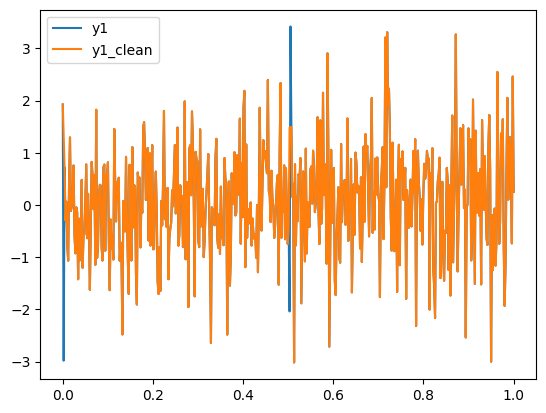

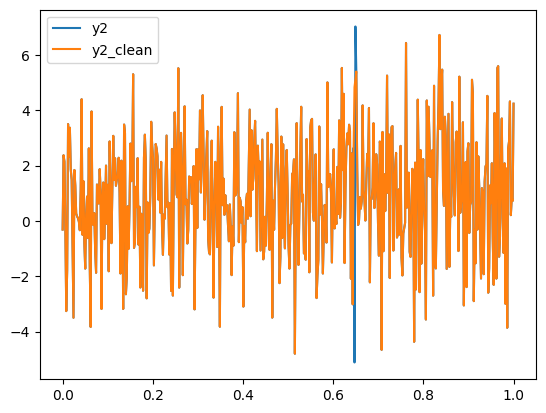

In [666]:
y1_clean = smoothing(y1, anom_y1)
y2_clean = smoothing(y2, anom_y2)

plt.plot(t, y1, label='y1')
plt.plot(t, y1_clean, label='y1_clean')
plt.legend()
plt.show()
plt.plot(t, y2, label='y2')
plt.plot(t, y2_clean, label='y2_clean')
plt.legend()
plt.show()

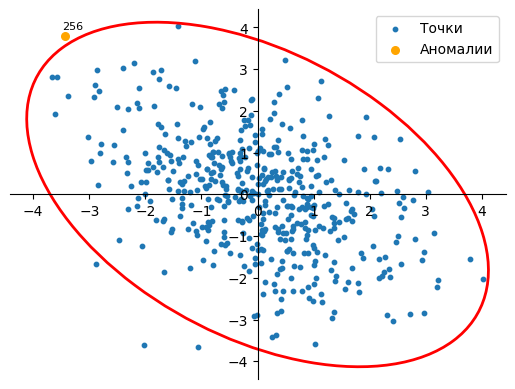

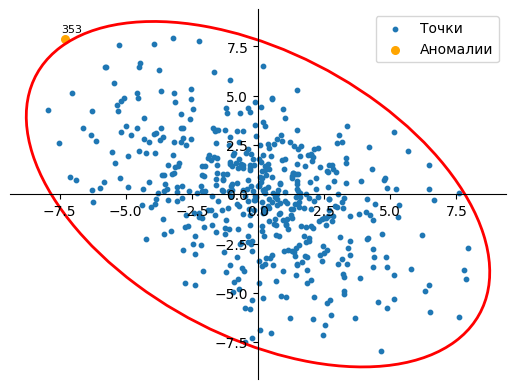

In [667]:
PARAM = 0.99

anom_y1 = ellips(y1_clean, PARAM)

anom_y2 = ellips(y2_clean, PARAM)

<h3>3) Исследование стационарности</h3>

In [668]:
def nums_max_series(X):
    # Нахождение кол-ва последовательностей и максимальной длины
    series, max_series = 1, 0
    current_length = 1

    for i in range(1, len(X)):
        if X[i] == X[i-1]:
            current_length += 1
        else:
            max_series = max(max_series, current_length)
            series += 1
            current_length = 1
    return series, max(max_series, current_length)

In [669]:
def median_test(Y):
    # Медианный тест
    test = []
    med = np.median(Y)
    for i in range(len(Y)):
        if Y[i] > med:
            test.append("+")
        elif Y[i] < med:
            test.append("-")

    series, max_series = nums_max_series(test)

    nu = 0.5 * (len(Y) + 2 - 1.96 * np.sqrt(len(Y) - 1))
    tau = 1.43 * np.log(len(Y) + 1)

    print(nu, series)
    print(tau, max_series)

    if series <= nu or max_series >= tau:
        return print("Отвергаем гипотезу об отсутствии тренда")
    else:
        return print("Принимает гипотезу об отсутствии тренда")



In [670]:
def up_down_test(Y):
  # Up down тест
  test = []
  for i in range(1,len(Y)):
    if Y[i] - Y[i - 1] > 0:
      test.append("+")
    elif Y[i] - Y[i - 1] < 0:
      test.append("-")

  series, max_series = nums_max_series(test)

  nu = (2 * 10 - 1)/3 - 1.96*np.sqrt((16*10 - 29)/90)
  tau = 6

  print(nu, series)
  print(tau, max_series)

  if series <= nu or max_series >= tau:
      return print("Отвергаем гипотезу об отсутствии тренда")
  else:
      return print("Принимает гипотезу об отсутствии тренда")


In [671]:
def means_50(Y):
    means = []
    for i in range(10):
        means.append(np.mean(Y[i*50:(i+1)*50]))
    return means

def vars_50(Y):
    vars = []
    for i in range(10):
        vars.append(np.var(Y[i*50:(i+1)*50]))
    return vars


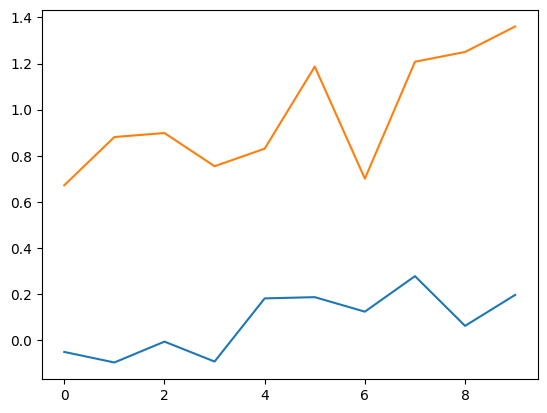

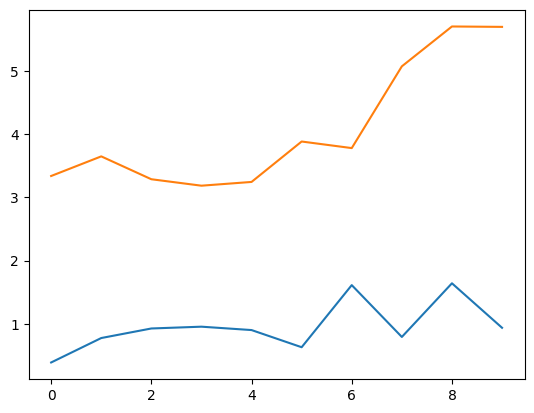

In [748]:
t10 = np.arange(10)
plt.plot(t10, means_50(y1_clean))
plt.plot(t10, vars_50(y1_clean))
plt.show()
plt.plot(t10, means_50(y2_clean))
plt.plot(t10, vars_50(y2_clean))
plt.show()

In [673]:
print('Y1\nmedian test:')
median_test(means_50(y1_clean))
median_test(vars_50(y1_clean))
print("\nUp&Down test:")
up_down_test(means_50(y1_clean))
up_down_test(vars_50(y1_clean))
print('\nY2\nMedian test:')
median_test(means_50(y2_clean))
median_test(vars_50(y2_clean))
print("\nUp&Down test:")
up_down_test(means_50(y2_clean))
up_down_test(vars_50(y2_clean))

Y1
median test:
3.06 4
3.42899024010167 4
Отвергаем гипотезу об отсутствии тренда
3.06 6
3.42899024010167 3
Принимает гипотезу об отсутствии тренда

Up&Down test:
3.968663753408429 8
6 2
Принимает гипотезу об отсутствии тренда
3.968663753408429 5
6 3
Принимает гипотезу об отсутствии тренда

Y2
Median test:
3.06 6
3.42899024010167 2
Принимает гипотезу об отсутствии тренда
3.06 2
3.42899024010167 5
Отвергаем гипотезу об отсутствии тренда

Up&Down test:
3.968663753408429 6
6 3
Принимает гипотезу об отсутствии тренда
3.968663753408429 6
6 2
Принимает гипотезу об отсутствии тренда


In [674]:
def AKF(X, k):
    # Оценка автокорреляционной функции
    Rxx = 0
    mean_X = np.mean(X)
    var_X = np.var(X)
    for i in range(0, len(X) - abs(k)):
        Rxx += (X[i] - mean_X) * (X[i+k] - mean_X) / (N - k)
    return Rxx / (var_X + 0.0001)

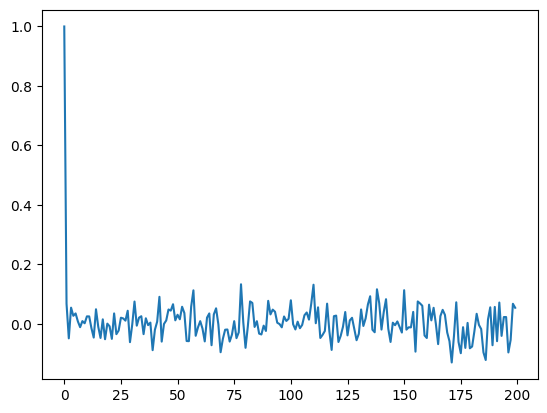

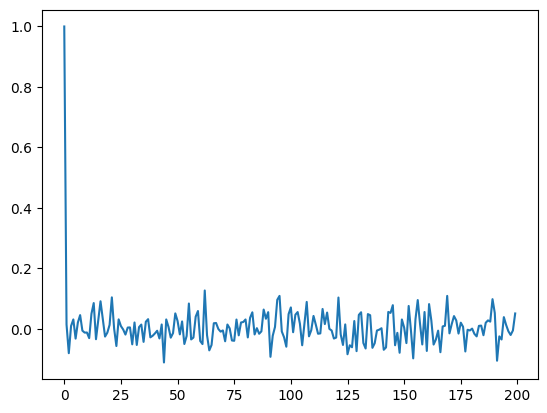

In [675]:
k = 200
m = np.arange(k)
Rxx = []

for i in m:
    Rxx.append(AKF(y1_clean, i))
plt.plot(m, Rxx)
plt.show()

Rxx = []
for i in m:
    Rxx.append(AKF(y2_clean, i))
plt.plot(m, Rxx)
plt.show()

In [676]:
def SPM(X, k):
    # Оценка спектральной плотность мощности
    Ixx = 0
    delta = T / N

    Ixx_1 = 0
    Ixx_2 = 0

    for i in range(0, N):
        Ixx_1 += X[i] * np.cos((2 * np.pi * k * i) / N)
        Ixx_2 += X[i] * np.sin((2 * np.pi * k * i) / N)

    Ixx = delta / N * (Ixx_1 ** 2 + Ixx_2 ** 2)
    return Ixx


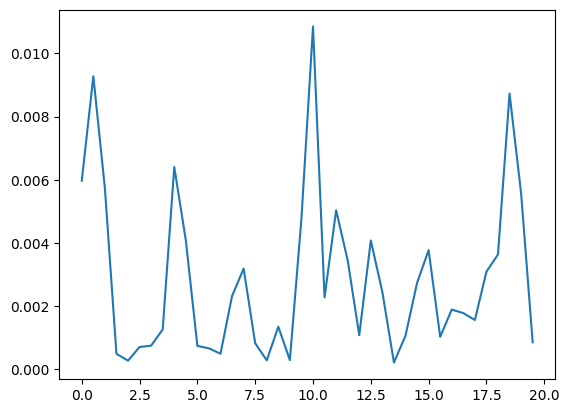

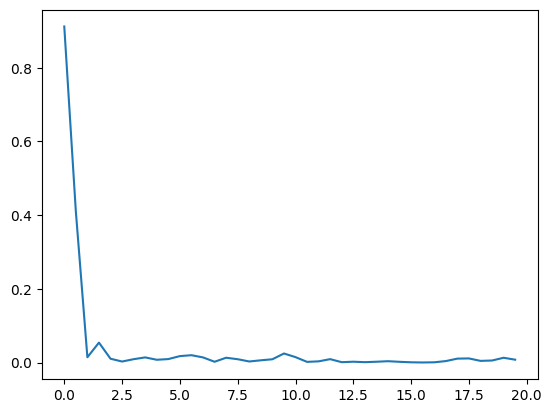

In [677]:
k = np.arange(0, 20, 0.5)
f = k / T

Sxx = []

for i in k:
    Sxx.append(SPM(y1_clean, i))
# print(Sxx[N])
plt.plot(f, Sxx)
plt.show()

Sxx = []
for i in k:
    Sxx.append(SPM(y2_clean, i))
# print(Sxx[N])
plt.plot(f, Sxx)
plt.show()

<h3>4) Выделение и удаление тренда</h3>

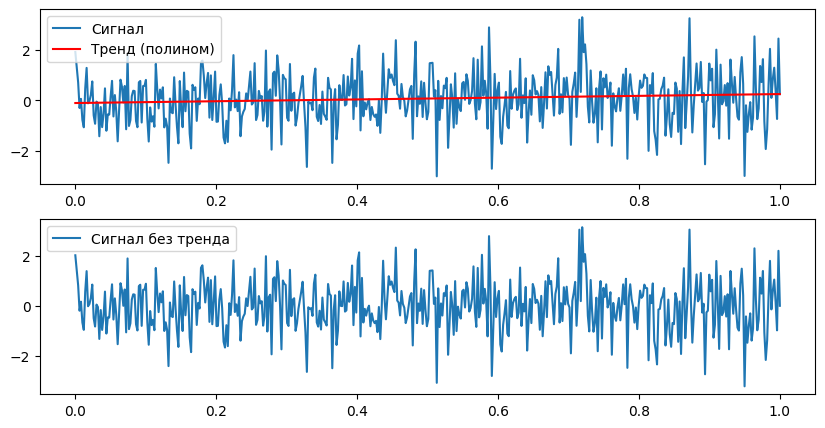

In [678]:
# степень полинома
degree = 1
coeffs = np.polyfit(t, y1_clean, degree)  # находим коэффициенты
trend = np.polyval(coeffs, t)      # считаем тренд

# удаляем тренд
detrended_y1 = y1_clean - trend

# визуализация
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(t, y1_clean, label="Сигнал")
plt.plot(t, trend, 'r', label="Тренд (полином)")
plt.legend()

plt.subplot(2,1,2)
plt.plot(t, detrended_y1, label="Сигнал без тренда")
plt.legend()
plt.show()

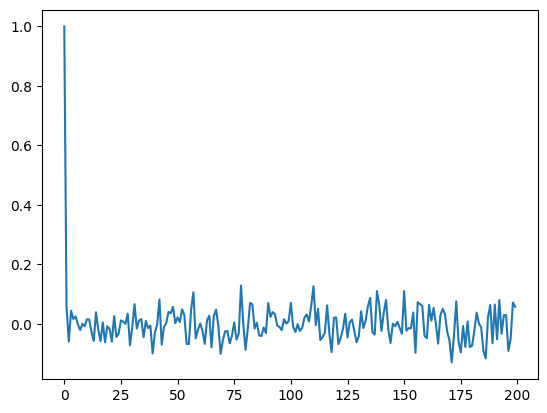

In [679]:
k = 200
m = np.arange(k)
Rxx = []

for i in m:
    Rxx.append(AKF(detrended_y1, i))
plt.plot(m, Rxx)
plt.show()

In [680]:
print(f'С трендом: среднее = {np.mean(y1_clean)} скр = {np.sqrt(np.var(y1_clean))}')
print(f'После удаления: среднее = {np.mean(detrended_y1)} скр = {np.sqrt(np.var(detrended_y1))}')

С трендом: среднее = 0.07727334104280309 скр = 0.9951735167008796
После удаления: среднее = 1.7763568394002505e-17 скр = 0.989828761124305


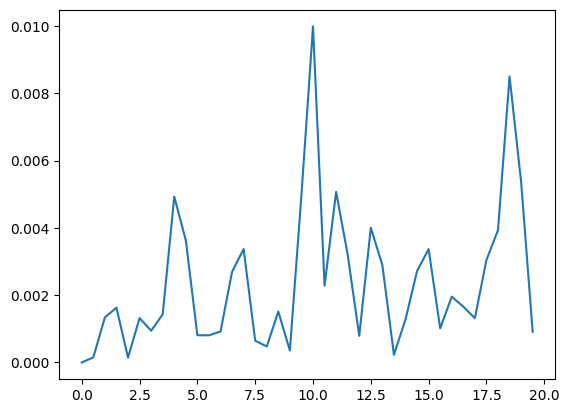

In [681]:
k = np.arange(0, 20, 0.5)
f = k / T

Sxx = []

for i in k:
    Sxx.append(SPM(detrended_y1, i))
# print(Sxx[N])
plt.plot(f, Sxx)
plt.show()

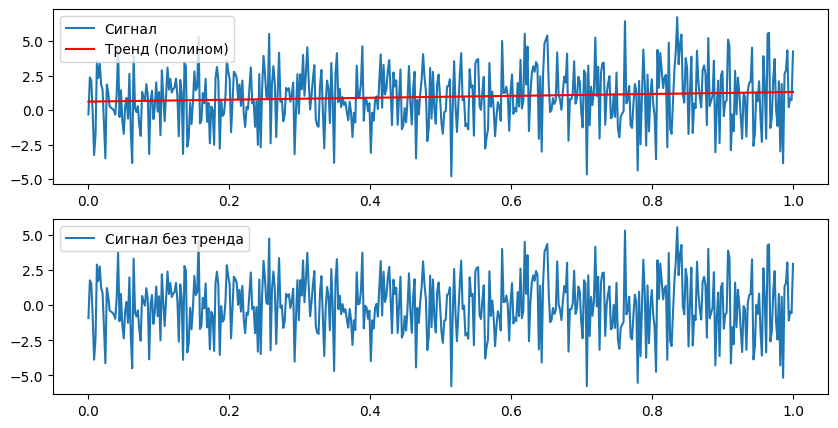

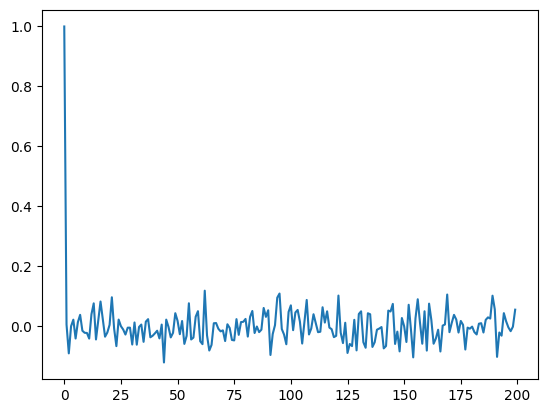

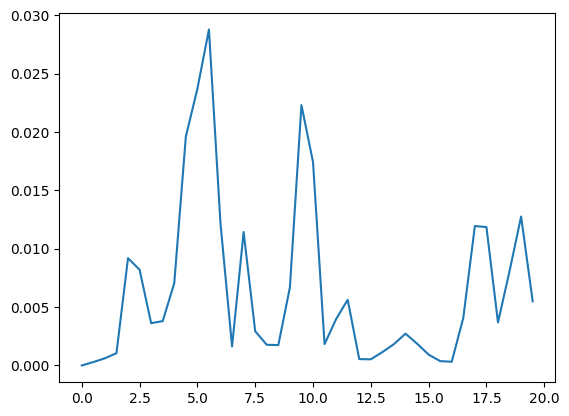

С трендом: среднее = 0.9549717543287018 скр = 2.055168854718508
После удаления: среднее = 9.237055564881302e-17 скр = 2.0453898647669777


In [682]:
# степень полинома
degree = 1
coeffs = np.polyfit(t, y2_clean, degree)  # находим коэффициенты
trend = np.polyval(coeffs, t)      # считаем тренд

# удаляем тренд
detrended_y2 = y2_clean - trend

# визуализация
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(t, y2_clean, label="Сигнал")
plt.plot(t, trend, 'r', label="Тренд (полином)")
plt.legend()

plt.subplot(2,1,2)
plt.plot(t, detrended_y2, label="Сигнал без тренда")
plt.legend()
plt.show()

k = 200
m = np.arange(k)
Rxx = []

for i in m:
    Rxx.append(AKF(detrended_y2, i))
plt.plot(m, Rxx)
plt.show()

k = np.arange(0, 20, 0.5)
f = k / T

Sxx = []

for i in k:
    Sxx.append(SPM(detrended_y2, i))
# print(Sxx[N])
plt.plot(f, Sxx)
plt.show()

print(f'С трендом: среднее = {np.mean(y2_clean)} скр = {np.sqrt(np.var(y2_clean))}')
print(f'После удаления: среднее = {np.mean(detrended_y2)} скр = {np.sqrt(np.var(detrended_y2))}')

In [683]:
from scipy import stats

stat, p = stats.shapiro(detrended_y1)  # Shapiro-Wilk тест
print("p-value =", p)

if p > 0.05:
    print("Не отвергаем гипотезу о номальности")
else:
    print("Отвергаем гипотезу о номальности")

stat, p = stats.shapiro(detrended_y2)  # Shapiro-Wilk тест
print("p-value =", p)

if p > 0.05:
    print("Не отвергаем гипотезу о номальности")
else:
    print("Отвергаем гипотезу о номальности")

p-value = 0.08416777984108795
Не отвергаем гипотезу о номальности
p-value = 0.4347461976051334
Не отвергаем гипотезу о номальности


<h3>5) АКФ И ВКФ для разных сигналов

In [684]:
def VKF(X, Y, k):
    # Оценка взаимной корреляционной функции
    Rxy = 0
    mean_X = np.mean(X)
    mean_Y = np.mean(Y)
    std_X = np.std(X) + 0.0001
    std_Y = np.std(Y) + 0.0001
    for i in range(0, len(X) - abs(k)):
        Rxy += (X[i] - mean_X) * (Y[i+k] - mean_Y) / (N - k)
    return Rxy / (std_X * std_Y)

In [685]:
def visual_akf_vkf(signal1, signal2):
  t = np.linspace(0, T, N)

  # Визуализация
  plt.plot(t, signal1)
  plt.plot(t, signal2)
  plt.title("Сигнал с линейной корреляцией (AR(1))")
  plt.show()

  # АКФ
  k = 200
  m = np.arange(k)
  Rxx = [AKF(signal1, i) for i in m]
  plt.plot(m, Rxx)
  plt.title("АКФ для линейно коррелированного сигнала")
  plt.show()

  # ВКФ
  Rxy = [VKF(signal1, signal2, i) for i in m]
  plt.plot(m, Rxy)
  plt.title("ВКФ для линейно коррелированных сигналов")
  plt.show()

<h4>Постоянный сигнал</h4>

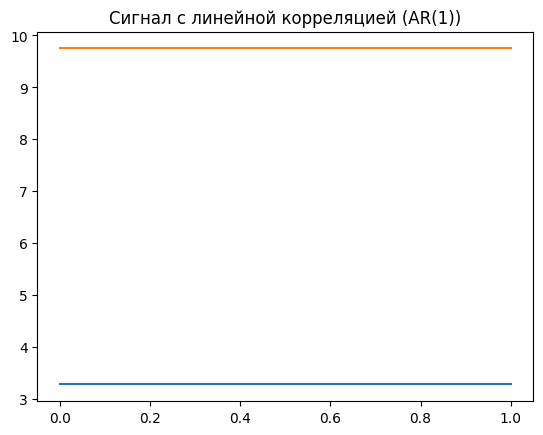

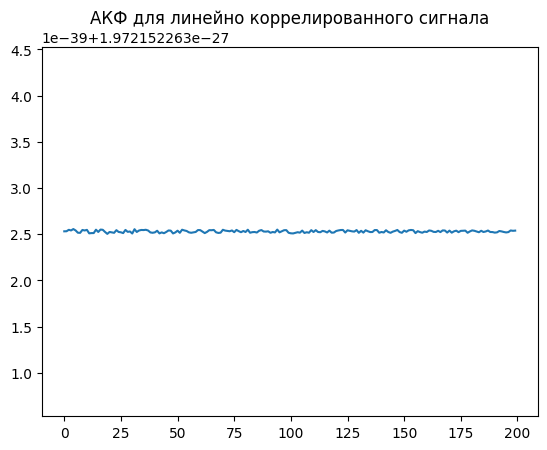

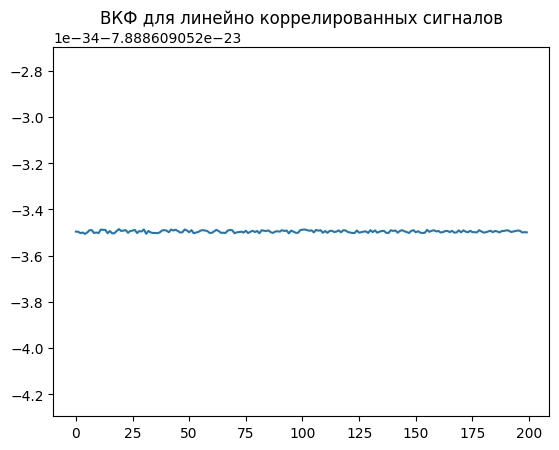

In [686]:
a1 =  np.random.uniform(1,10)
a2 = np.random.uniform(1,10)
signal_a = np.full(N, a1)
signal_a2 = np.full(N, a2)

visual_akf_vkf(signal_a, signal_a2)

<h4>Белый шум

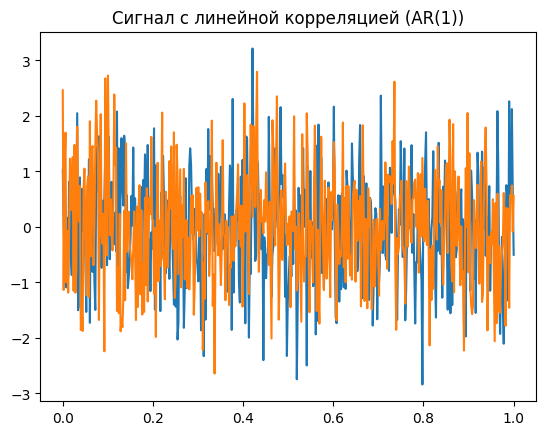

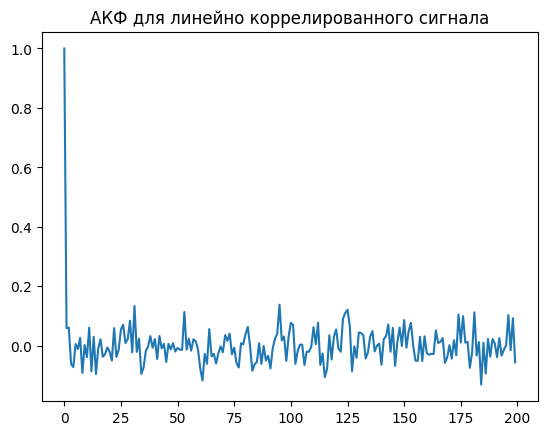

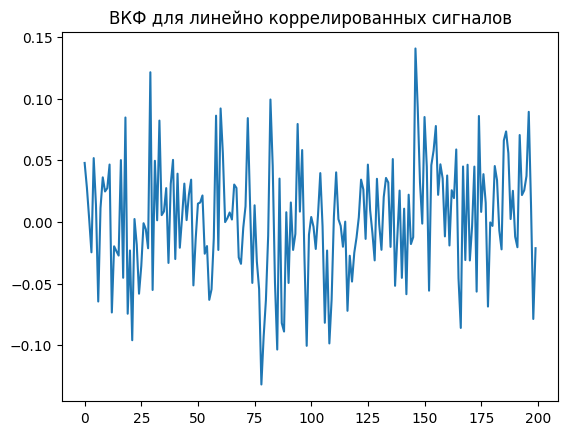

In [687]:
signal_b =  np.random.normal(loc=0, scale=1, size=N)
signal_b2 =  np.random.normal(loc=0, scale=1, size=N)

visual_akf_vkf(signal_b, signal_b2)

<h4>Несколько частотных составляющих</h4>

In [688]:
def sin_signal(f1, f2, f3, time):
    a1 = np.random.uniform(1,10)
    a2 = np.random.uniform(1,10)
    a3 = np.random.uniform(1,10)
    signal = []
    for t in time:
        signal.append(a1 * np.sin(f1 * 2 * np.pi * t) + a2 * np.sin(f2 * 2 * np.pi * t) + a3 * np.sin(f3 * 2 * np.pi * t))
    return signal

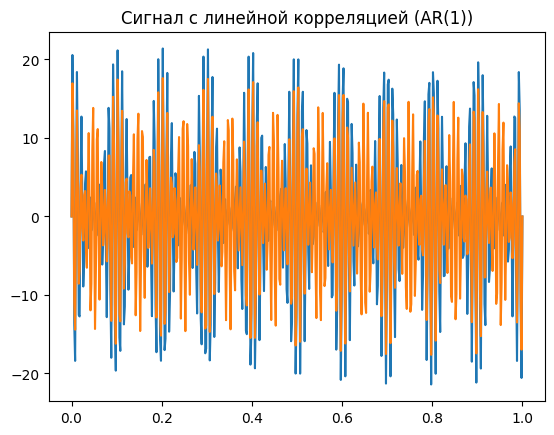

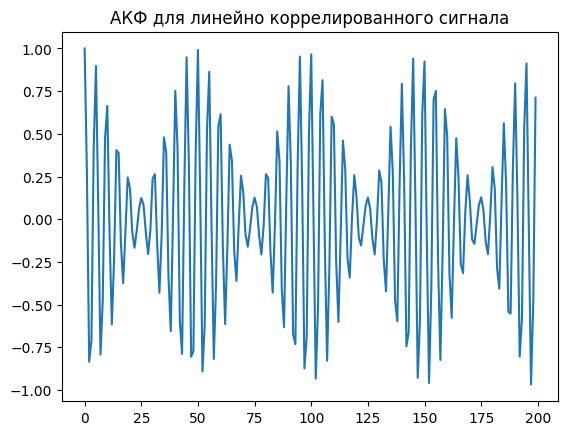

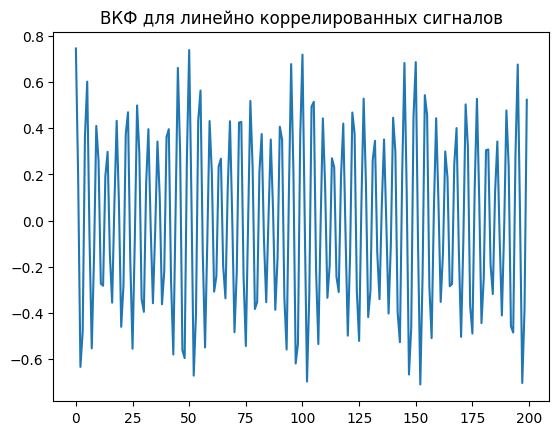

In [749]:
signal_c = sin_signal(90, 100, 110, t)
signal_c2 = sin_signal(90, 100, 110, t)

visual_akf_vkf(signal_c, signal_c2)

<h4>Линейно коррелированные отсчеты

In [690]:
def correlated_signal(N, alpha=0.8):
    e = np.random.normal(0, 1, N)
    x = np.zeros(N)
    for i in range(1, N):
        x[i] = alpha * x[i - 1] + e[i]
    return x


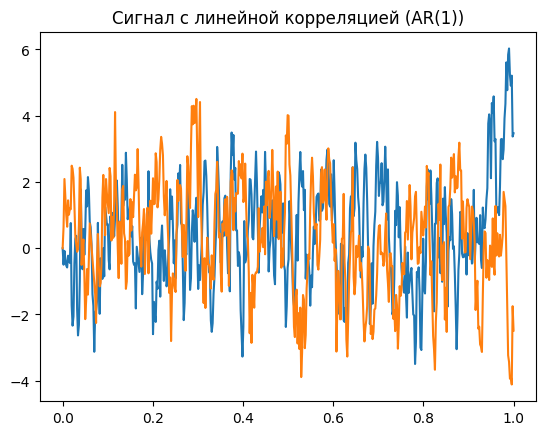

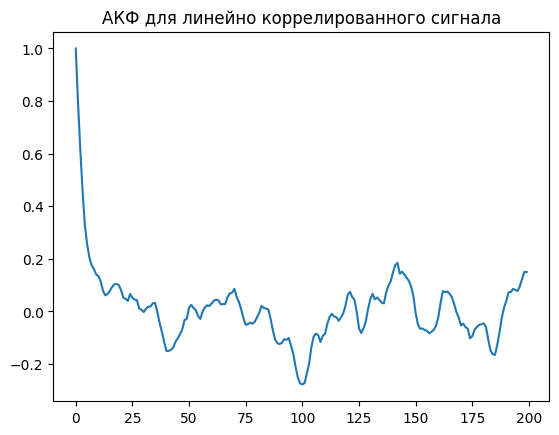

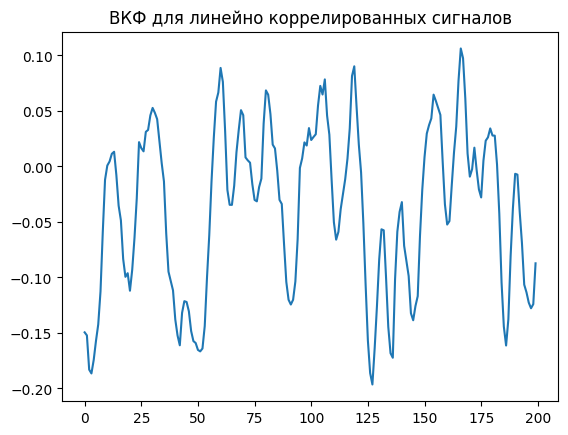

In [752]:
signal_d = correlated_signal(N, alpha=0.8)
signal_d2 = correlated_signal(N, alpha=0.8)

visual_akf_vkf(signal_d, signal_d2)

<h3>6) Оконные функции

In [716]:
def SPM_windowed(X, k, window_func):
    # Применяем оконную функцию
    if window_func is not False:
      X_windowed = X * window_func
    else:
      X_windowed = X

    delta = T / N
    Ixx_1 = 0
    Ixx_2 = 0

    for i in range(0, N):
        Ixx_1 += X_windowed[i] * np.cos((2 * np.pi * k * i) / N)
        Ixx_2 += X_windowed[i] * np.sin((2 * np.pi * k * i) / N)

    Ixx = delta / N * (Ixx_1 ** 2 + Ixx_2 ** 2)
    return Ixx

In [722]:
def compare_SPM_windows(signal, signal_name):
    """Сравнение СПМ с различными оконными функциями"""
    k = np.arange(0, 50, 0.5)
    f = k / T

    windows = {
        'Пустое' : False,
        'Прямоугольное': np.ones(N),
        'Бартлетта': np.bartlett(N),
        'Хемминга': np.hamming(N),
        'Хана': np.hanning(N)
    }

    plt.figure(figsize=(12, 8))

    for i, (name, window_func) in enumerate(windows.items(), 1):
        Sxx = [SPM_windowed(signal, freq, window_func) for freq in k]
        plt.subplot(2, 3, i)
        plt.plot(f, Sxx)
        plt.title(f'СПМ ({name} окно) - {signal_name}')
        plt.xlabel('Частота, Гц')
        plt.ylabel('СПМ')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

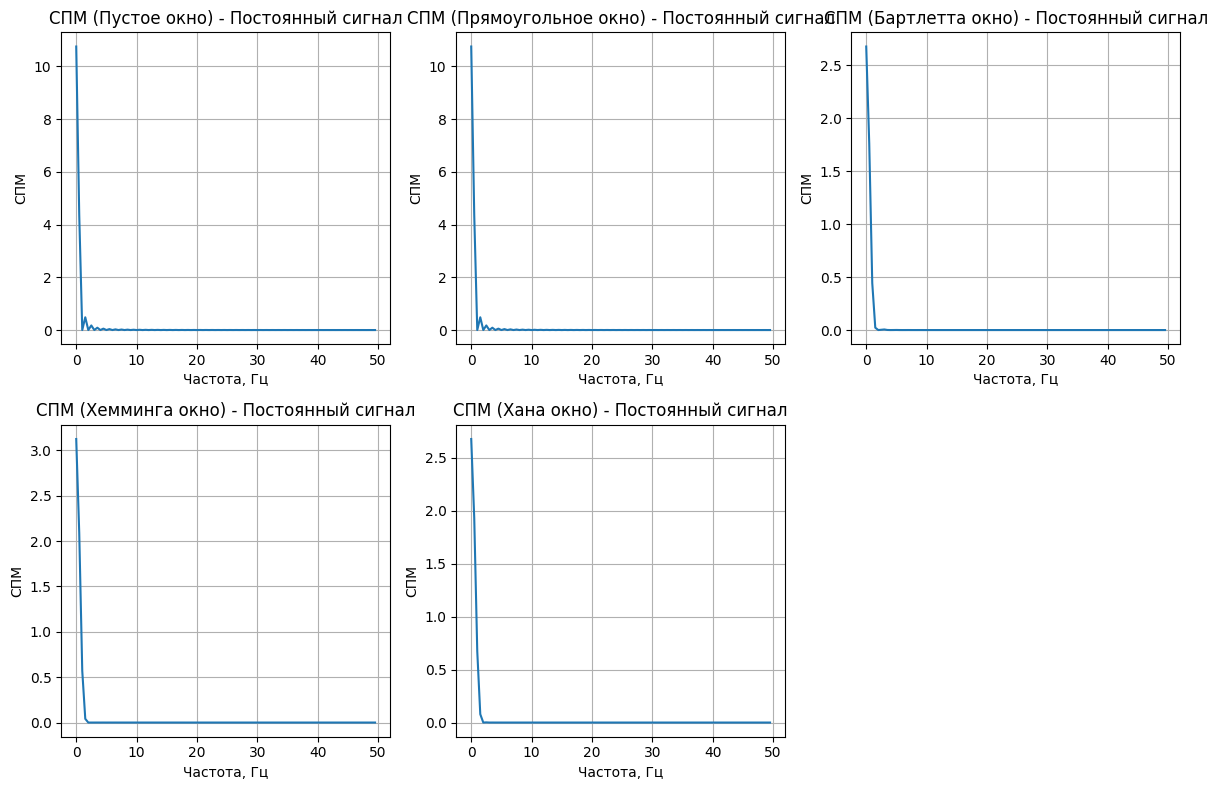

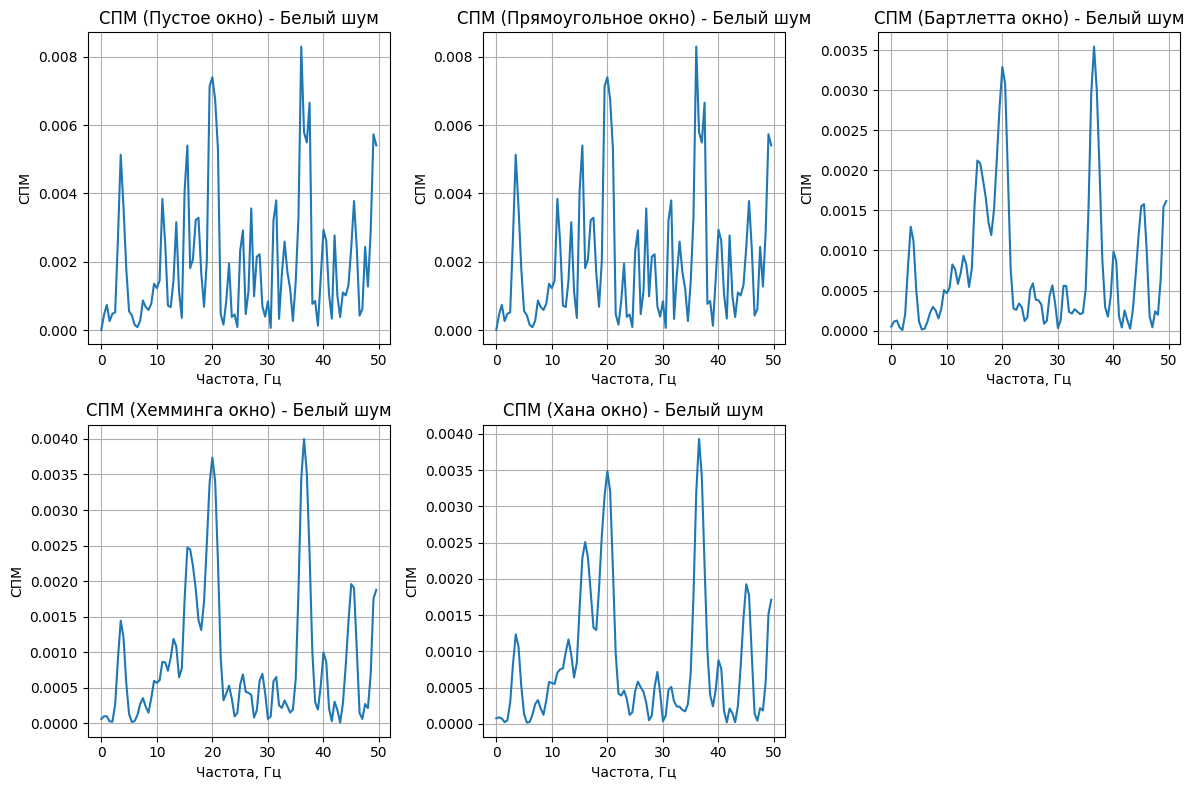

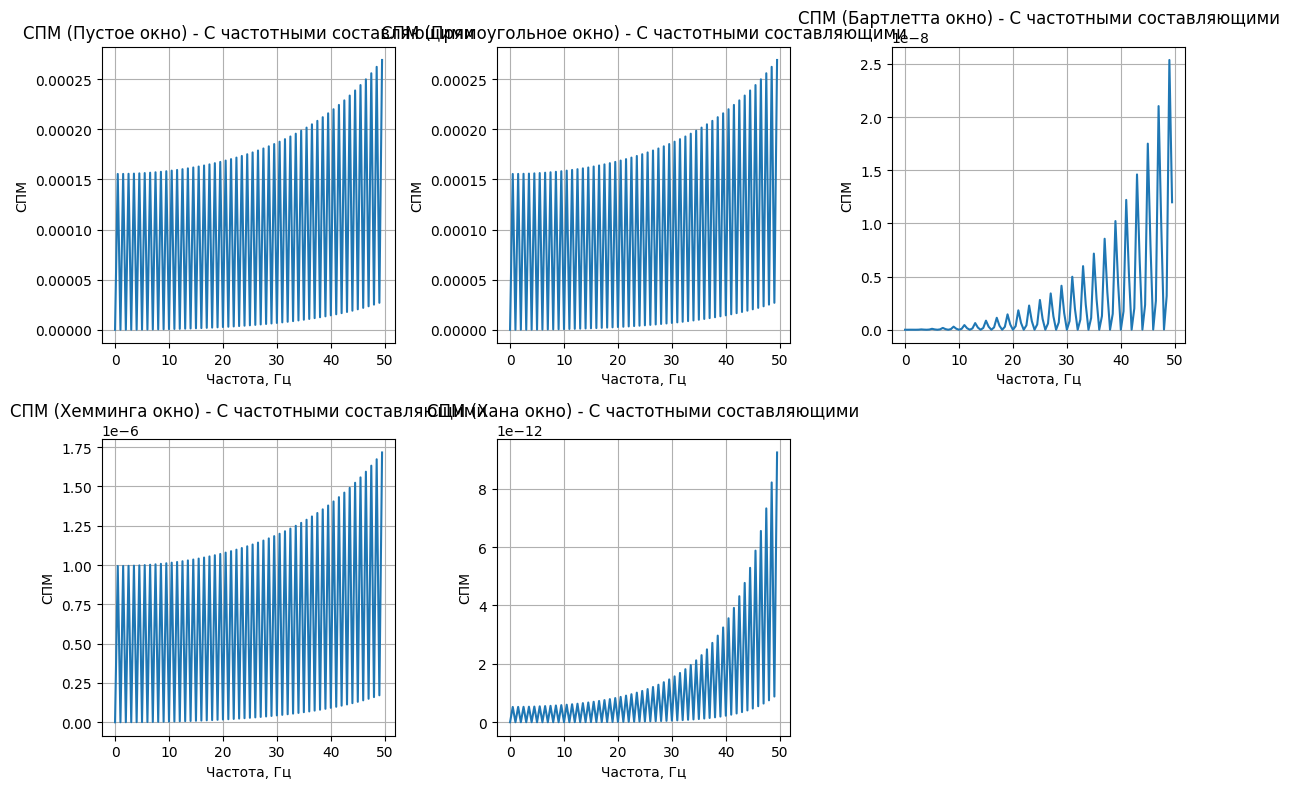

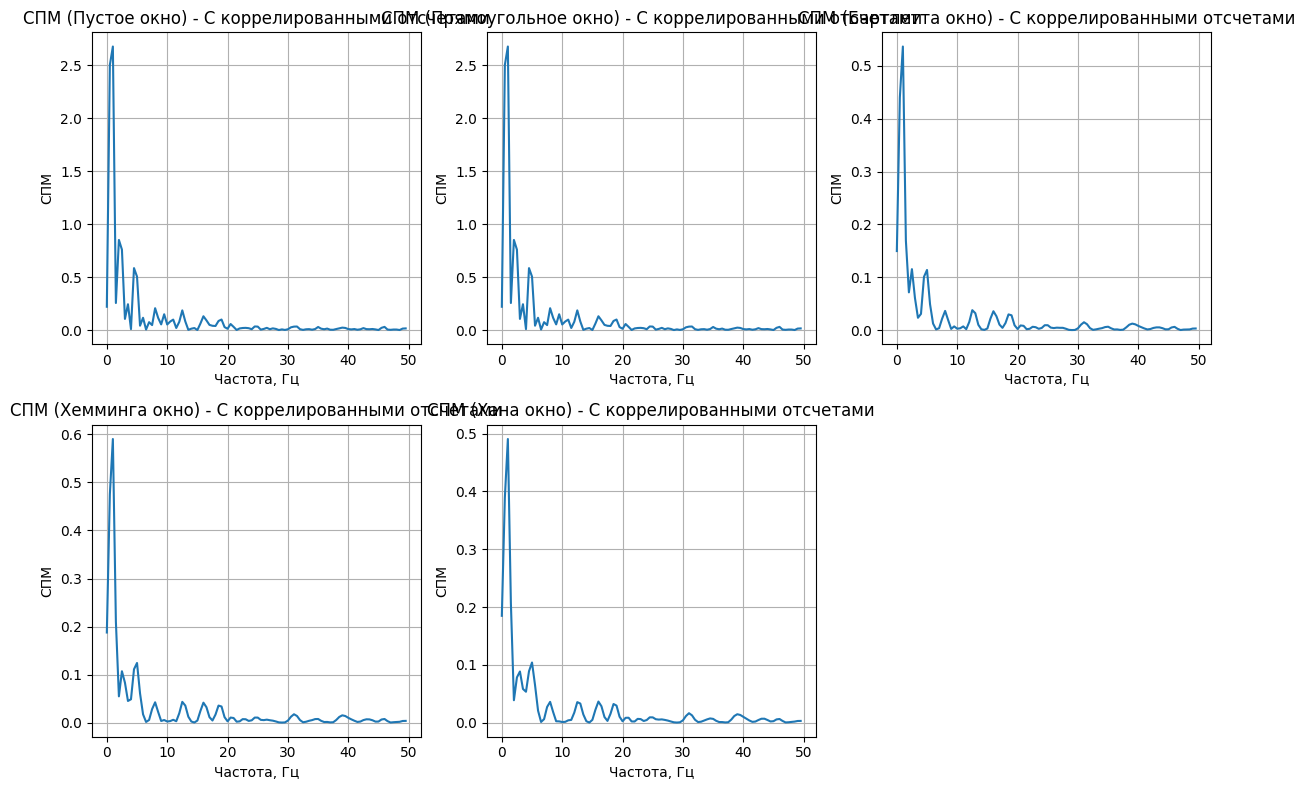

In [723]:
signals = {
    "Постоянный сигнал" : signal_a,
    "Белый шум" : signal_b,
    "С частотными составляющими" : signal_c,
    "С коррелированными отсчетами" : signal_d
}

for name, signal in signals.items():
  compare_SPM_windows(signal, name)


<h3>7) СПМ и ВСПМ для двух синусов

In [730]:
def VSPM(X, Y, k):
    N = len(X)
    X_n = np.array(X) - np.mean(X)
    Y_n = np.array(Y) - np.mean(Y)
    X_n = X_n * np.hanning(len(X_n))
    Y_n = Y_n * np.hanning(len(X_n))
    Re_xy = 0
    Im_xy = 0

    for i in range(N):
        angle = (2 * np.pi * k * i) / N
        Re_xy += X_n[i] * np.cos(angle) * Y_n[i]
        Im_xy += X_n[i] * np.sin(angle) * Y_n[i]

    Sxy = (Re_xy - 1j * Im_xy) / N
    return Sxy

In [697]:
def signal1(f1, f2, f3, t, e):
    return 2*np.sin(f1*t*2*np.pi)+1.7*np.sin(f2*t*2*np.pi)+2.3*np.sin(f3*t*2*np.pi)+0.2*e
def signal2(f1, f2, f3, t,e):
    return 1.6*np.sin(f1*t*2*np.pi)+2.1*np.sin(f2*t*2*np.pi)+2.0*np.sin(f3*t*2*np.pi)+0.2*e

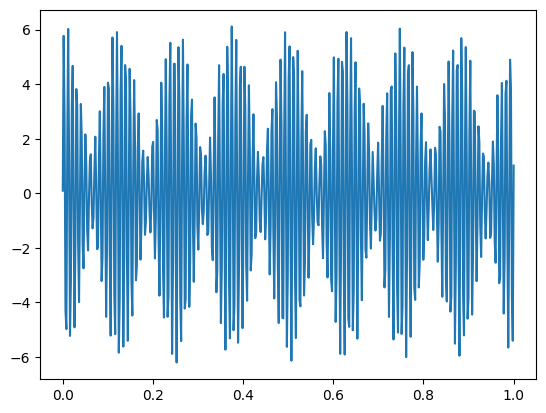

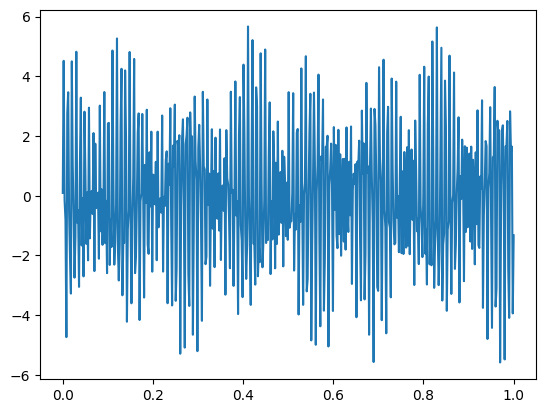

In [698]:
e = np.random.normal(loc=0, scale=1, size=N)
signal_x = []
signal_y = []

for i in range(N):
    signal_x.append(signal1(102, 102.08, 110, t[i], e[i]))
    signal_y.append(signal2(102.8, 110, 210, t[i], e[i]))

plt.plot(t, signal_x)
plt.show()
plt.plot(t, signal_y)
plt.show()

[102.0, 110.0]


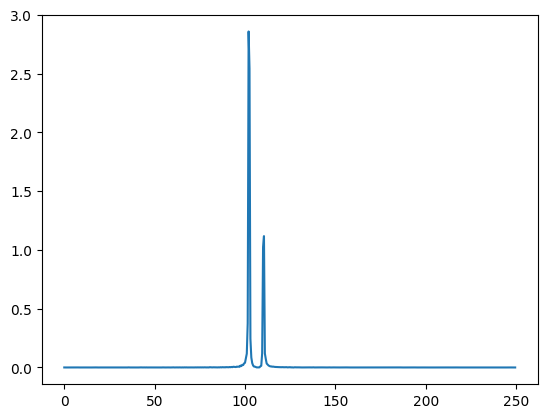

[103.0, 110.0, 210.0]


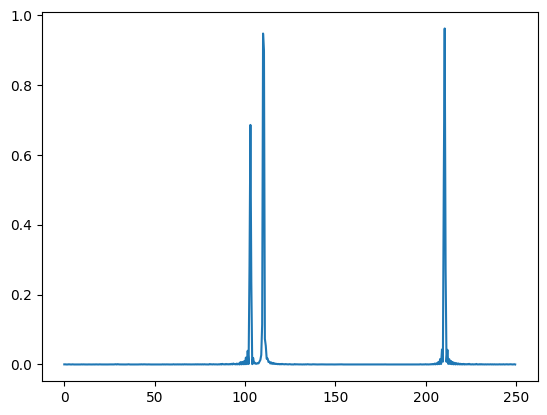

In [746]:
k = np.arange(0, 250, 0.5)
f = k / T

Sxx = []
freqs = [0]
l = 0
for i in k:
    Sxx.append(SPM(signal_x, i))
    if Sxx[l] > 0.5 and abs(freqs[-1] - i) > 1:
        freqs.append(float(i))
    l += 1
print(freqs[1:])
plt.plot(f, Sxx)
plt.show()

Sxx = []
freqs = [0]
l = 0
for i in k:
    Sxx.append(SPM(signal_y, i))
    if Sxx[l] > 0.5 and abs(freqs[-1] - i) > 1:
        freqs.append(float(i))
    l += 1
print(freqs[1:])
plt.plot(f, Sxx)
plt.show()

[7.0, 99.5, 107.0, 109.5, 178.5, 186.0, 188.5, 204.5, 211.5, 219.5]


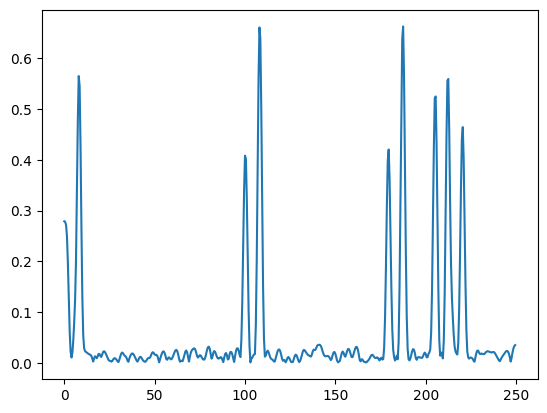

In [747]:
Sxy = []
freqs = [0]
l = 0
for i in k:
    Sxy.append(np.abs(VSPM(signal_x, signal_y, i)))
    if Sxy[l] > 0.3 and abs(freqs[-1] - i) > 2:
        freqs.append(float(i))
    l += 1
print(freqs[1:])
plt.plot(f, Sxy)
plt.show()
